In [1]:
import tifffile
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from skimage import segmentation
from scipy.ndimage import binary_dilation
from scipy.ndimage import distance_transform_edt
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
import anndata as ad
import json
import os

In [2]:
def process_full_image(cell_df, seg_mask_path, target_col, label_col='label'):
    segmentation_mask = tifffile.imread(seg_mask_path) # read the whole segmentation mask - adapt code if lazy loading is needed
    mask = np.isin(segmentation_mask, cell_df[label_col].values) # filter out cells not in the cell dataframe based on cell id, e.g. if removing artefacts
    segmentation_mask[~mask] = 0

    plot_segmentation = np.zeros(segmentation_mask.shape, dtype=np.uint8) # create an empty array for plotting - this array will be filled with cell type labels
    unique_identifiers = set(cell_df[target_col].unique())
    for i, identifier in enumerate(unique_identifiers):
        print(identifier, i+1)
        layer_labels = cell_df.loc[cell_df[target_col] == identifier, label_col] # Thanks Lukas for catching this
        plot_segmentation[np.isin(segmentation_mask, layer_labels)] = i+1
    
    return segmentation_mask, plot_segmentation

def crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right):
    roi_crop = segmentation_mask[ ROI_upper_left[0]:ROI_lower_right[0], ROI_upper_left[1]:ROI_lower_right[1]]
    plot_crop = plot_segmentation[ROI_upper_left[0]:ROI_lower_right[0], ROI_upper_left[1]:ROI_lower_right[1]]
    return roi_crop, plot_crop

def create_plot(roi_crop, plot_crop, cmap, boundaries=False, boundary_color=(0, 0, 0, 1), boundary_thickness=1,save_path=None):
    plt.figure(figsize=(10, 10))
    plt.gca().set_aspect('equal', adjustable='box')
    scalebar = ScaleBar(1, 'um', location='lower left')
    plt.gca().add_artist(scalebar)
    plt.imshow(plot_crop, cmap=cmap, interpolation='none')
    if boundaries:
        boundaries_prediction = segmentation.find_boundaries(roi_crop, mode='thick')
        for _ in range(boundary_thickness - 1):  # Apply dilation multiple times for thicker boundaries
            boundaries_prediction = binary_dilation(boundaries_prediction)
        # Create an RGBA overlay: boundary pixels get the specified color, others are transparent
        boundary_overlay = np.zeros((*boundaries_prediction.shape, 4))  # Initialize as transparent
        boundary_overlay[boundaries_prediction] = boundary_color  # Assign color where boundary is detected

        # Overlay the boundaries while keeping the original image
        plt.imshow(boundary_overlay, interpolation='none')
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)


In [3]:
extension = 'png'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_1/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_1/{extension}/'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/neighborhood_color_map.json', 'r') as f:
    neighborhood_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/phenotype_color_map.json', 'r') as f:
    phenotype_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease_color_map.json', 'r') as f:
    disease_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease3_color_map.json', 'r') as f:
    disease3_color_map = json.load(f)
neighborhood_colors = [neighborhood_color_map[cat] for cat in list(adata.obs['cellcharter_CN'].cat.categories)]
phenotype_colors = [phenotype_color_map[cat] for cat in list(adata.obs['Phenotype4'].cat.categories)]
disease_colors = [disease_color_map[cat] for cat in list(adata.obs['disease2'].cat.categories)]
disease3_colors = [disease3_color_map[cat] for cat in list(adata.obs['disease3'].cat.categories)]

In [4]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC26_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (215, 0)
ROI_lower_right = (715,500)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)

Macs/monos 1
OB/RUNX2+ 2
Neutrophils 3
CD8 T 4
PCs 5
HSPCs 6
CD4 T 7
DCs 8
HLA-DR+ Macs/monos 9
Endothelial 10
MPO+ 11
Adipocytes 12
Unknown 13


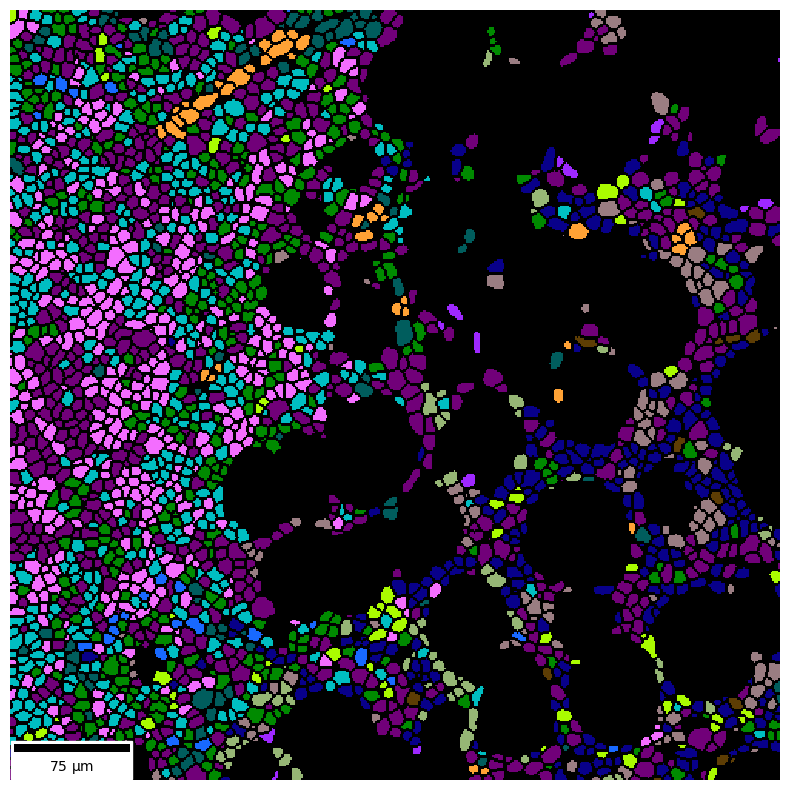

In [5]:
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

Macs/monos 1
Osteoclasts 2
OB/RUNX2+ 3
Neutrophils 4
HSPCs 5
PCs 6
CD8 T 7
HLA-DR+ Macs/monos 8
CD4 T 9
Osteocytes 10
Endothelial 11
MPO+ 12
Adipocytes 13
DCs 14
Unknown 15


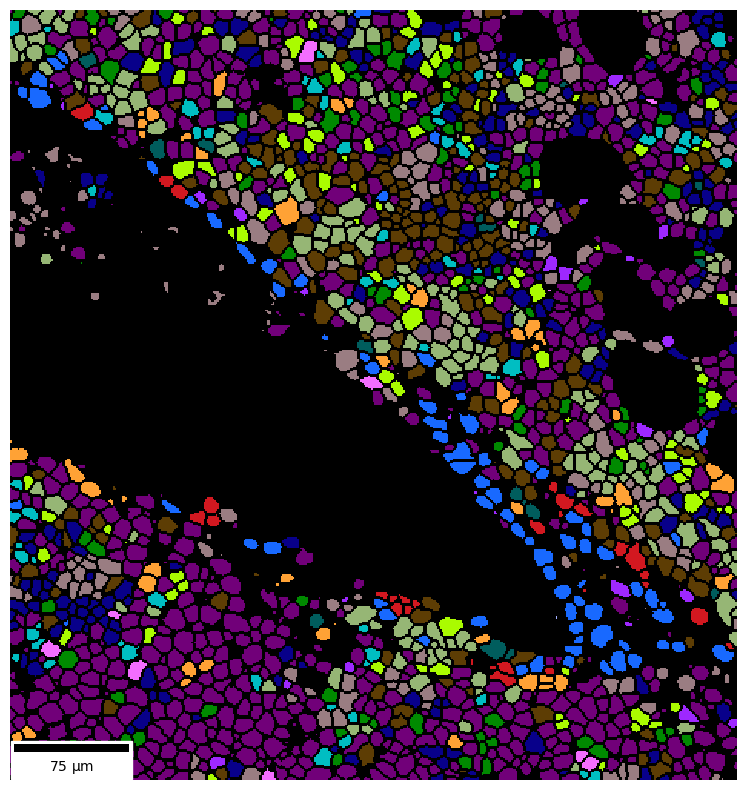

In [6]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC66_B_002.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (52, 452)
ROI_lower_right = (553,925)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

Macs/monos 1
Osteoclasts 2
OB/RUNX2+ 3
PCs 4
HSPCs 5
Neutrophils 6
HLA-DR+ Macs/monos 7
CD8 T 8
DCs 9
CD4 T 10
Endothelial 11
MPO+ 12
Adipocytes 13
Osteocytes 14
Unknown 15


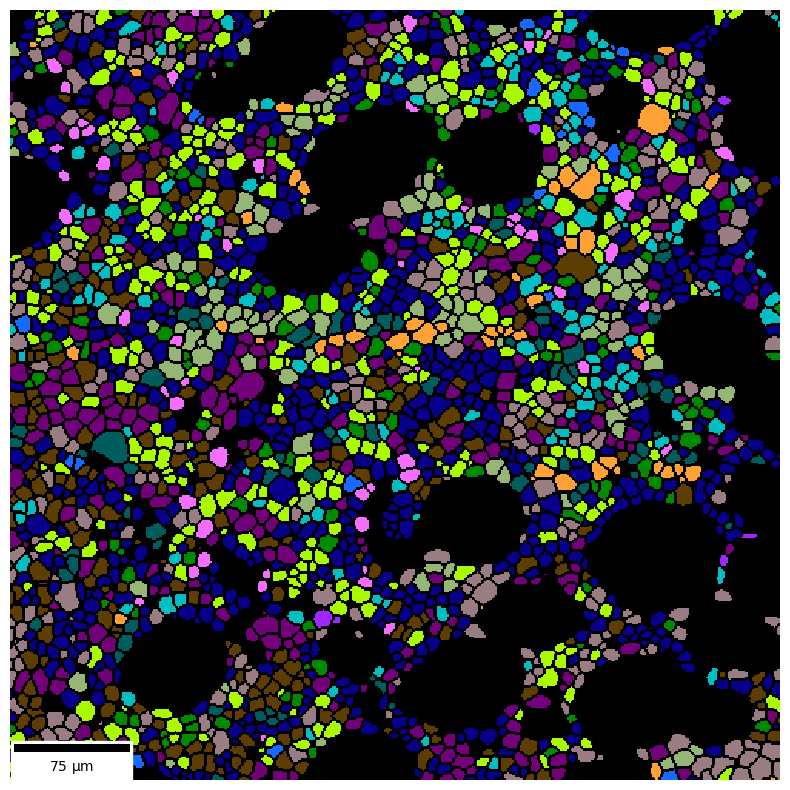

In [7]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC60-1_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (203, 163)
ROI_lower_right = (703,663)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

# Figure 2

Macs/monos 1
Osteoclasts 2
OB/RUNX2+ 3
Neutrophils 4
HSPCs 5
PCs 6
HLA-DR+ Macs/monos 7
DCs 8
Endothelial 9
Osteocytes 10
CD8 T 11
MPO+ 12
CD4 T 13
Adipocytes 14
Unknown 15


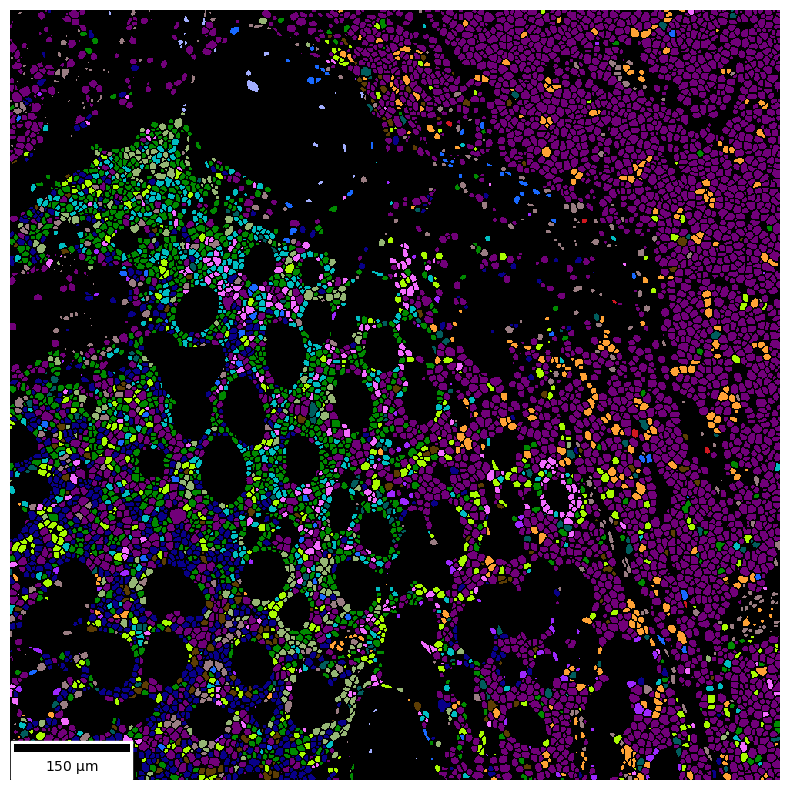

In [8]:
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_2/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_2/{extension}/'
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC75-1_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

PROLIF_GLYC 1
BONE_MYELOID 2
BONE_ADIPOCYTES 3
ADAPTIVE_IMMUNE 4
ADIPOCYTES_PC 5
PC_OXPHOS 6
PC_MYELOID 7
HIF1A_IMMUNE 8
BONE_VASCULATURE 9


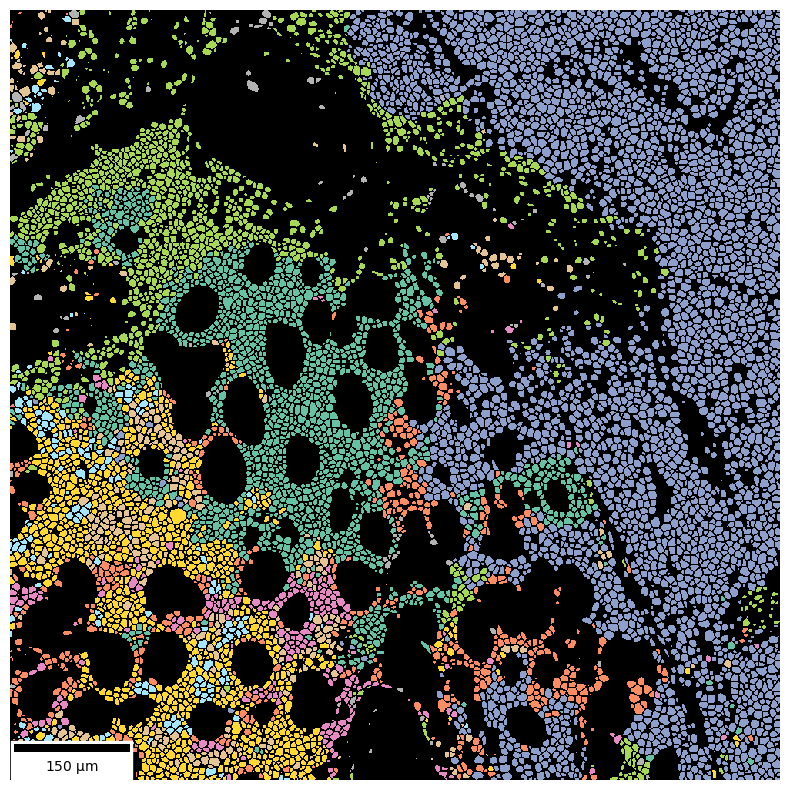

In [10]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC75-1_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'cellcharter_CN' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [neighborhood_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

# Figure 3

Macs/monos 1
Osteoclasts 2
OB/RUNX2+ 3
PCs 4
Neutrophils 5
HSPCs 6
HLA-DR+ Macs/monos 7
CD4 T 8
DCs 9
Endothelial 10
Adipocytes 11
MPO+ 12
Osteocytes 13
CD8 T 14
Unknown 15


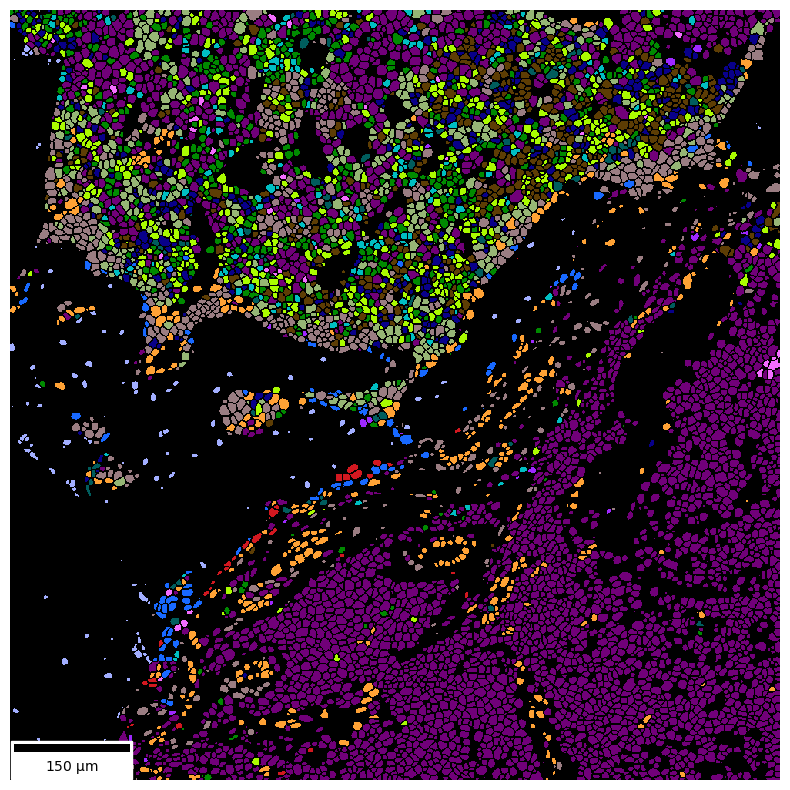

In [11]:
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_3/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_3/{extension}/'
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC43_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

ADAPTIVE_IMMUNE 1
BONE_VASCULATURE 2
ADIPOCYTES_PC 3
PC_OXPHOS 4
PC_MYELOID 5
PROLIF_GLYC 6
BONE_MYELOID 7
BONE_ADIPOCYTES 8
HIF1A_IMMUNE 9


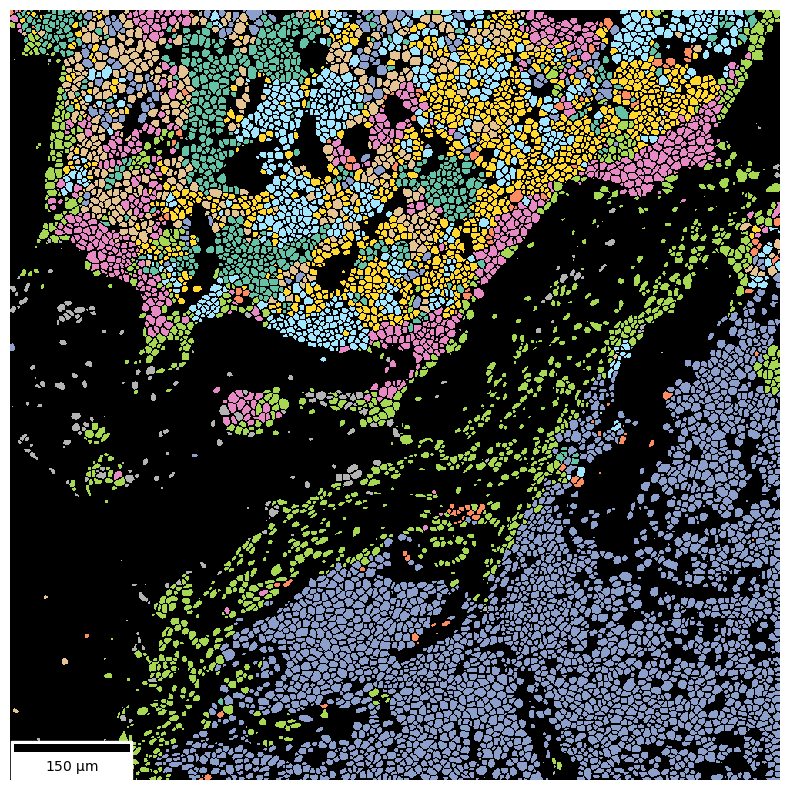

In [11]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC43_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'cellcharter_CN' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [neighborhood_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

In [12]:
neighborhood_color_map

{'ADAPTIVE_IMMUNE': [0.4, 0.7607843137254902, 0.6470588235294118],
 'ADIPOCYTES_PC': [0.9882352941176471, 0.5529411764705883, 0.3843137254901961],
 'BONE_ADIPOCYTES': [0.7019607843137254,
  0.7019607843137254,
  0.7019607843137254],
 'BONE_MYELOID': [0.9058823529411765, 0.5411764705882353, 0.7647058823529411],
 'BONE_VASCULATURE': [0.6509803921568628,
  0.8470588235294118,
  0.32941176470588235],
 'HIF1A_IMMUNE': [1.0, 0.8509803921568627, 0.1843137254901961],
 'PC_MYELOID': [0.8980392156862745, 0.7686274509803922, 0.5803921568627451],
 'PC_OXPHOS': [0.5529411764705883, 0.6274509803921569, 0.796078431372549],
 'PROLIF_GLYC': [0.6352941176470588, 0.9058823529411765, 1.0]}

In [13]:
neighborhood_color_map2 = neighborhood_color_map.copy()
for key in neighborhood_color_map.keys():
    if key not in ['PC_OXPHOS', 'PC_MYELOID']:
        neighborhood_color_map2[key] = 'grey'
neighborhood_color_map2

{'ADAPTIVE_IMMUNE': 'grey',
 'ADIPOCYTES_PC': 'grey',
 'BONE_ADIPOCYTES': 'grey',
 'BONE_MYELOID': 'grey',
 'BONE_VASCULATURE': 'grey',
 'HIF1A_IMMUNE': 'grey',
 'PC_MYELOID': [0.8980392156862745, 0.7686274509803922, 0.5803921568627451],
 'PC_OXPHOS': [0.5529411764705883, 0.6274509803921569, 0.796078431372549],
 'PROLIF_GLYC': 'grey'}

ADAPTIVE_IMMUNE 1
BONE_VASCULATURE 2
ADIPOCYTES_PC 3
PC_OXPHOS 4
PC_MYELOID 5
PROLIF_GLYC 6
BONE_MYELOID 7
BONE_ADIPOCYTES 8
HIF1A_IMMUNE 9


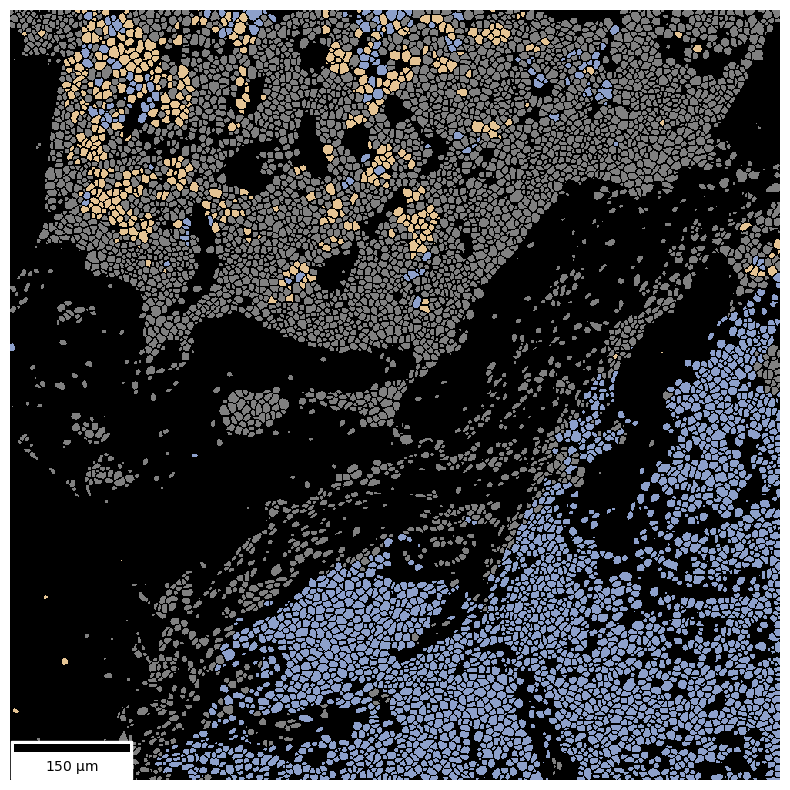

In [14]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC43_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'cellcharter_CN' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
neighborhood_color_map2 = neighborhood_color_map.copy()
for key in neighborhood_color_map.keys():
    if key not in ['PC_OXPHOS', 'PC_MYELOID']:
        neighborhood_color_map2[key] = 'grey'
colors_list = [background_color] + [neighborhood_color_map2[identifier] for identifier in unique_identifiers]
colors_list
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_greyed.{extension}')
            )

ADAPTIVE_IMMUNE 1
BONE_VASCULATURE 2
ADIPOCYTES_PC 3
PC_OXPHOS 4
PC_MYELOID 5
PROLIF_GLYC 6
BONE_MYELOID 7
BONE_ADIPOCYTES 8
HIF1A_IMMUNE 9


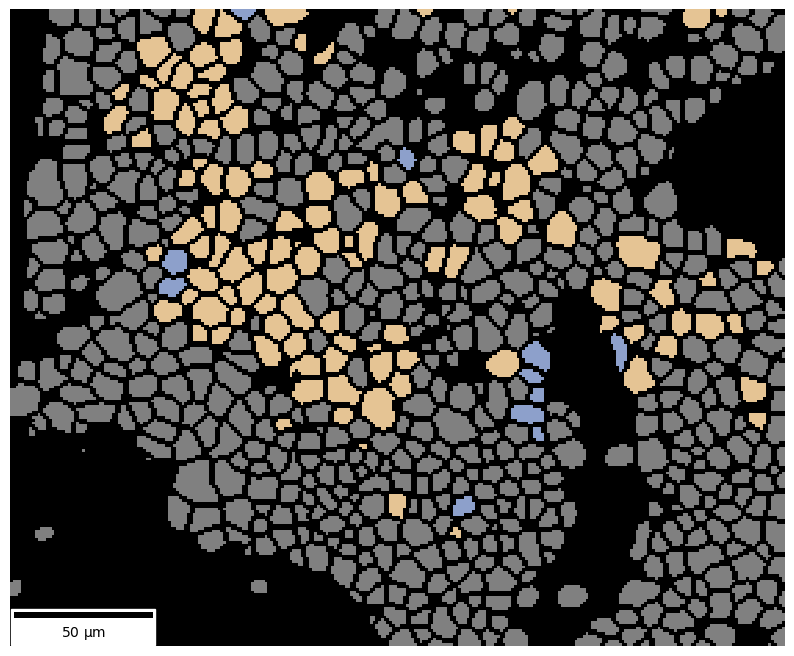

In [15]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC43_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'cellcharter_CN' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (150, 40)
ROI_lower_right = (380,320)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
neighborhood_color_map2 = neighborhood_color_map.copy()
for key in neighborhood_color_map.keys():
    if key not in ['PC_OXPHOS', 'PC_MYELOID']:
        neighborhood_color_map2[key] = 'grey'
colors_list = [background_color] + [neighborhood_color_map2[identifier] for identifier in unique_identifiers]
colors_list
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_greyed_crop1.{extension}')
            )

Macs/monos 1
Osteoclasts 2
OB/RUNX2+ 3
Neutrophils 4
PCs 5
HSPCs 6
HLA-DR+ Macs/monos 7
DCs 8
Endothelial 9
Adipocytes 10
CD4 T 11
MPO+ 12
Osteocytes 13
CD8 T 14
Unknown 15


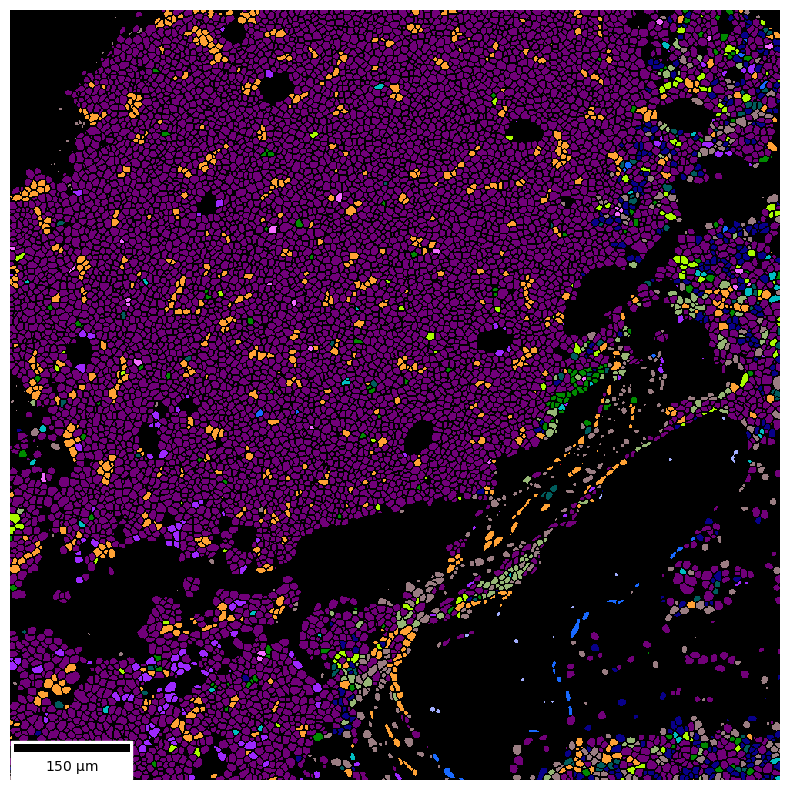

In [12]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC71_B_002.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

PROLIF_GLYC 1
BONE_MYELOID 2
BONE_ADIPOCYTES 3
ADAPTIVE_IMMUNE 4
ADIPOCYTES_PC 5
PC_OXPHOS 6
PC_MYELOID 7
HIF1A_IMMUNE 8
BONE_VASCULATURE 9


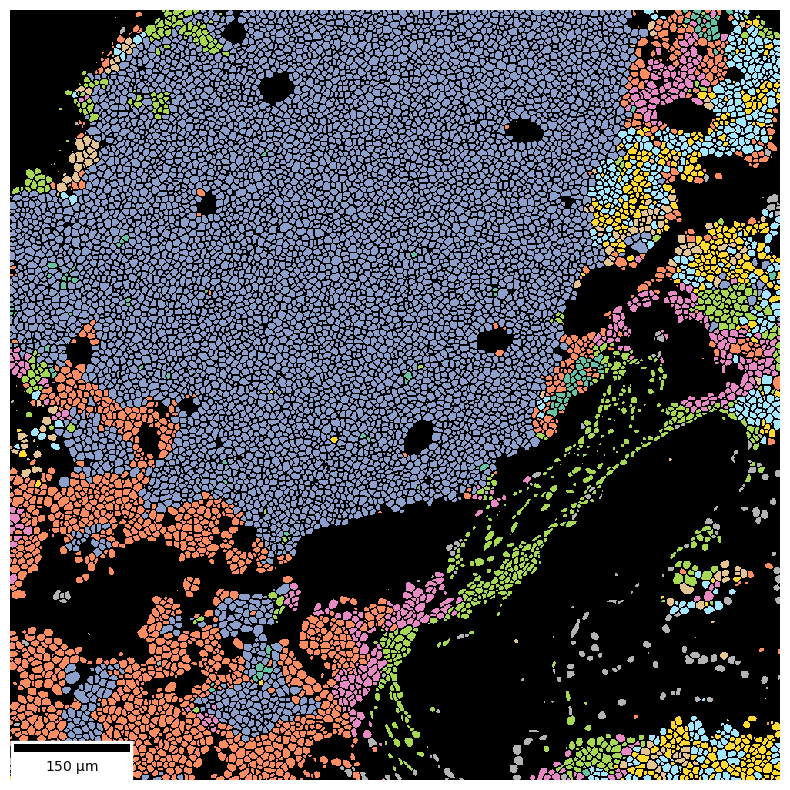

In [13]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC71_B_002.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'cellcharter_CN' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [neighborhood_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

OB/RUNX2+ 1
Unknown 2
DCs 3
MPO+ 4
HSPCs 5
PCs 6
Osteocytes 7
HLA-DR+ Macs/monos 8
Neutrophils 9
CD4 T 10
Macs/monos 11
Adipocytes 12
Osteoclasts 13
CD8 T 14
Endothelial 15


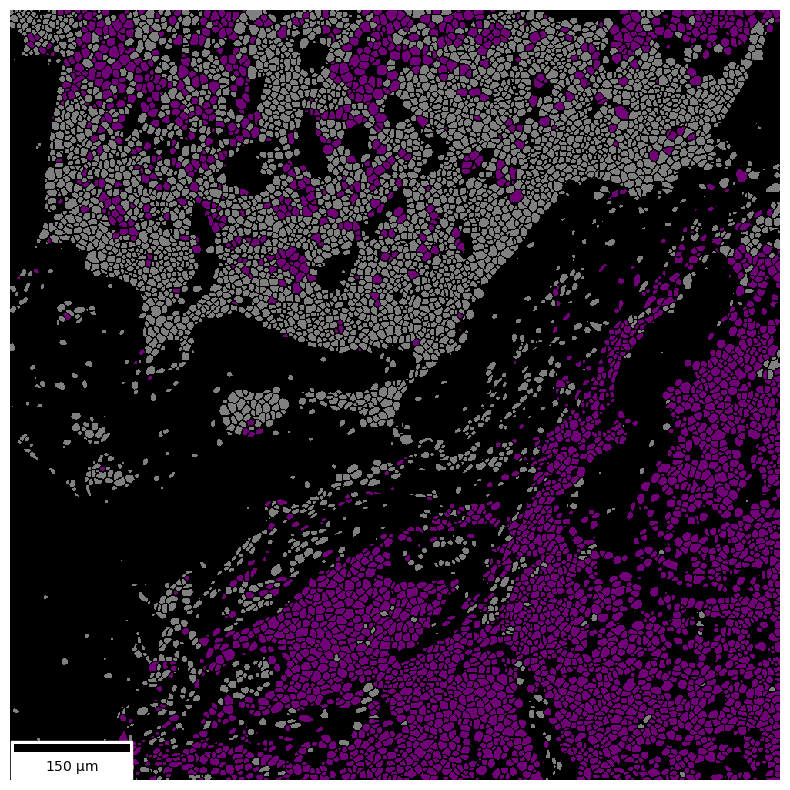

In [18]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC43_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
phenotype_color_map2 = phenotype_color_map.copy()
for key in phenotype_color_map.keys():
    if key not in ['PCs']:
        phenotype_color_map2[key] = 'grey'
colors_list = [background_color] + [phenotype_color_map2[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_greyed.{extension}')
            )

# Figure 4

OB/RUNX2+ 1
Unknown 2
DCs 3
MPO+ 4
HSPCs 5
PCs 6
CD8 T 7
Osteocytes 8
HLA-DR+ Macs/monos 9
Neutrophils 10
CD4 T 11
Adipocytes 12
Macs/monos 13
Endothelial 14


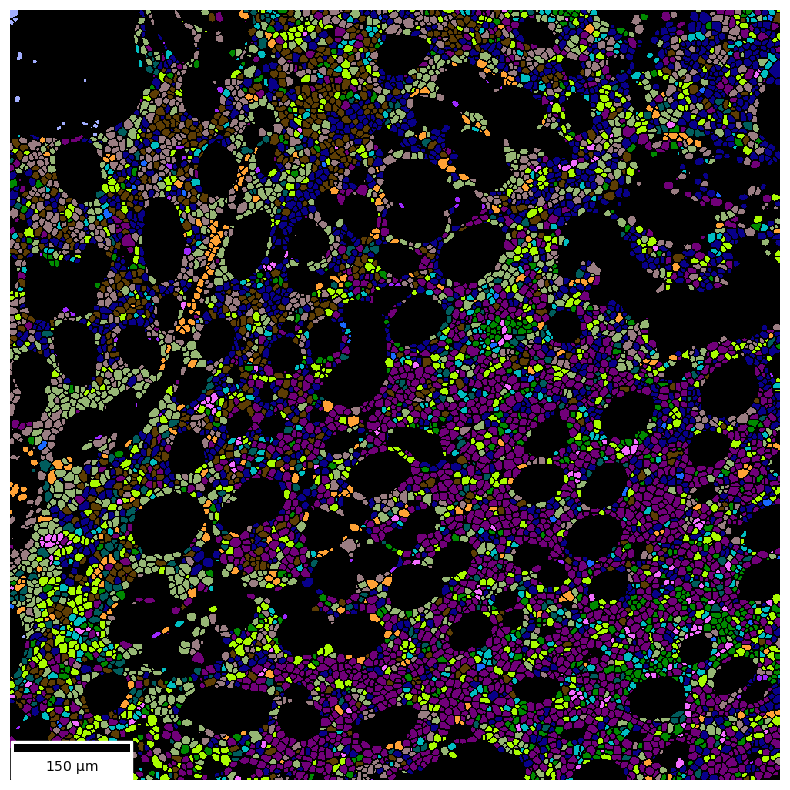

In [19]:
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_4/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_4/{extension}/'
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC42_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

OB/RUNX2+ 1
Unknown 2
DCs 3
MPO+ 4
HSPCs 5
PCs 6
CD8 T 7
Osteocytes 8
HLA-DR+ Macs/monos 9
Neutrophils 10
CD4 T 11
Adipocytes 12
Macs/monos 13
Endothelial 14


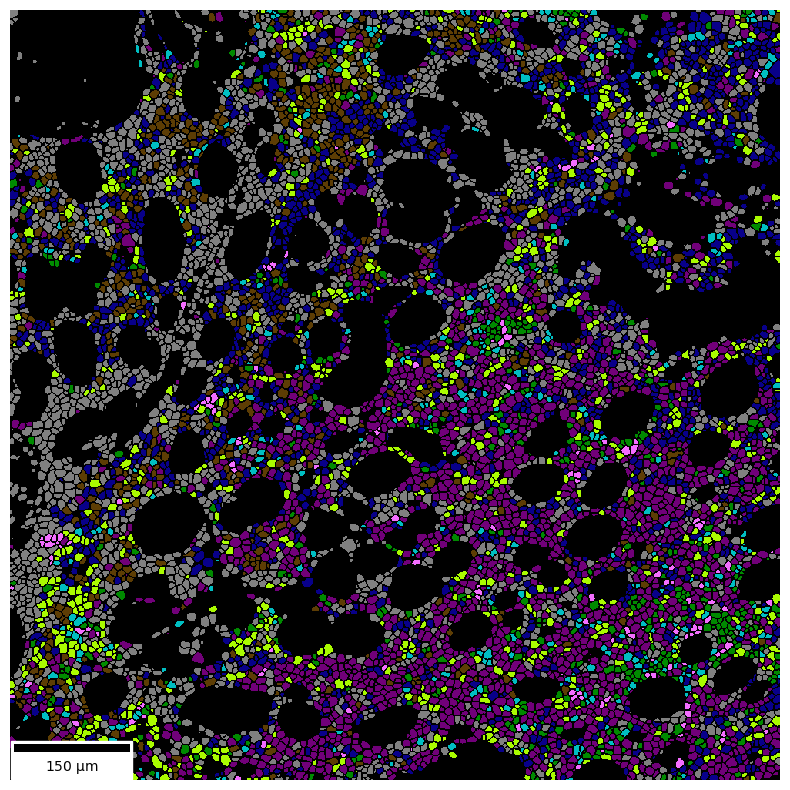

In [20]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC42_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
phenotype_color_map2 = phenotype_color_map.copy()
for key in phenotype_color_map.keys():
    if key not in ['PCs', 'Neutrophils', 'DCs', 'CD4 T', 'CD8 T', 'Macs/monos', 'HLA-DR+ Macs/monos']:
        phenotype_color_map2[key] = 'grey'
colors_list = [background_color] + [phenotype_color_map2[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_greyed.{extension}'))

ADAPTIVE_IMMUNE 1
BONE_VASCULATURE 2
ADIPOCYTES_PC 3
PROLIF_GLYC 4
PC_MYELOID 5
PC_OXPHOS 6
BONE_MYELOID 7
BONE_ADIPOCYTES 8
HIF1A_IMMUNE 9


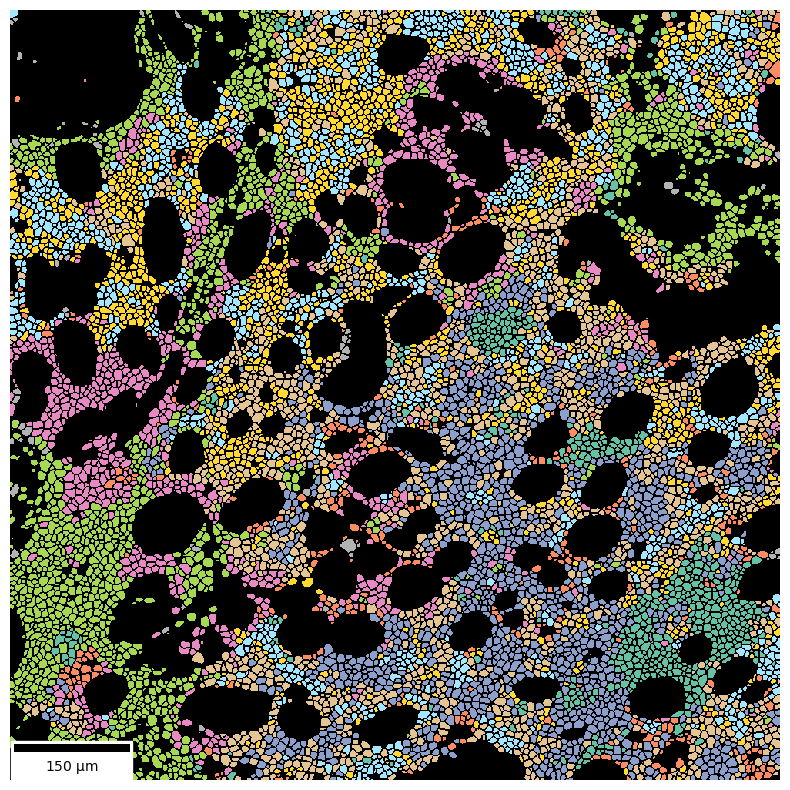

In [21]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC42_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'cellcharter_CN' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [neighborhood_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}.{extension}')
            )

ADAPTIVE_IMMUNE 1
BONE_VASCULATURE 2
ADIPOCYTES_PC 3
PROLIF_GLYC 4
PC_MYELOID 5
PC_OXPHOS 6
BONE_MYELOID 7
BONE_ADIPOCYTES 8
HIF1A_IMMUNE 9


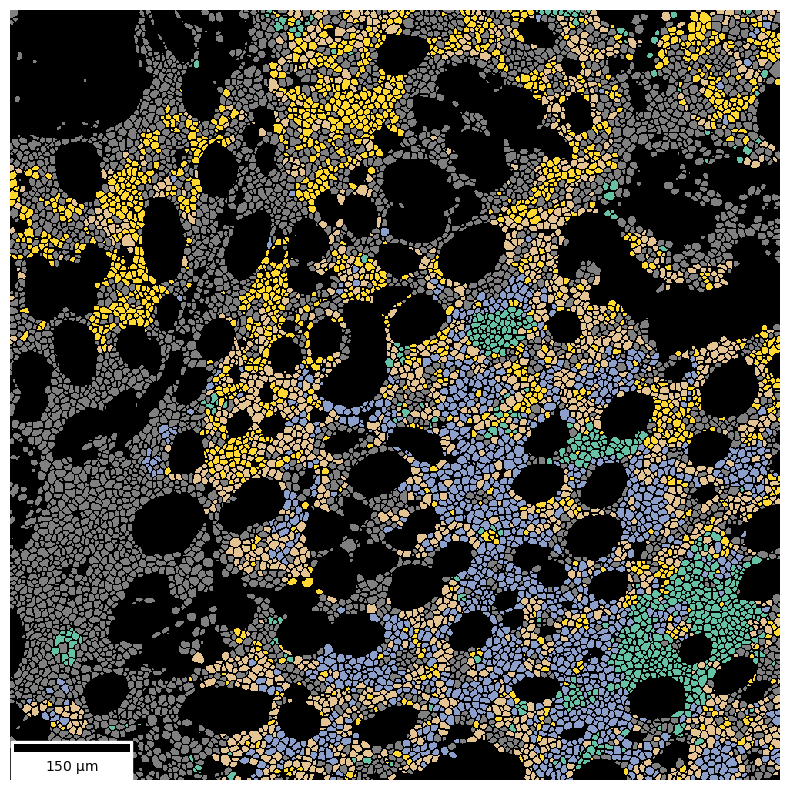

In [22]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC42_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'cellcharter_CN' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
neighborhood_color_map2 = neighborhood_color_map.copy()
for key in neighborhood_color_map.keys():
    if key not in ['PC_OXPHOS', 'PC_MYELOID', 'ADAPTIVE_IMMUNE', 'HIF1A_IMMUNE']:
        neighborhood_color_map2[key] = 'grey'
colors_list = [background_color] + [neighborhood_color_map2[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_greyed.{extension}')
            )

OB/RUNX2+ 1
Unknown 2
DCs 3
MPO+ 4
HSPCs 5
PCs 6
CD8 T 7
Osteocytes 8
HLA-DR+ Macs/monos 9
Neutrophils 10
CD4 T 11
Macs/monos 12
Adipocytes 13
Osteoclasts 14
Endothelial 15


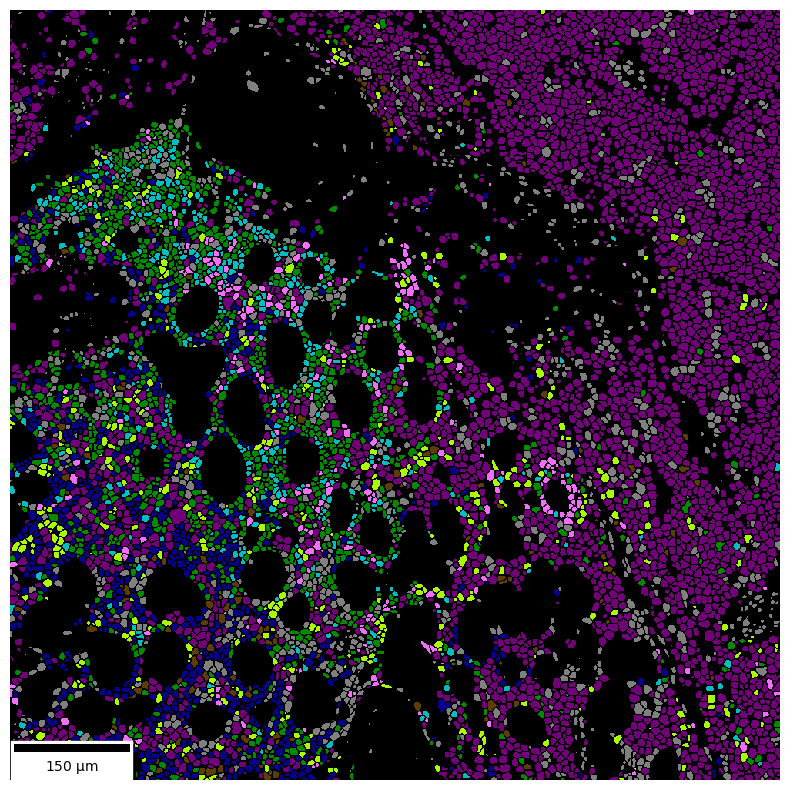

In [23]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC75-1_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
phenotype_color_map2 = phenotype_color_map.copy()
for key in phenotype_color_map.keys():
    if key not in ['PCs', 'Neutrophils', 'DCs', 'CD4 T', 'CD8 T', 'Macs/monos', 'HLA-DR+ Macs/monos']:
        phenotype_color_map2[key] = 'grey'
colors_list = [background_color] + [phenotype_color_map2[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_greyed.{extension}'))

ADAPTIVE_IMMUNE 1
BONE_VASCULATURE 2
ADIPOCYTES_PC 3
PC_OXPHOS 4
PC_MYELOID 5
PROLIF_GLYC 6
BONE_MYELOID 7
BONE_ADIPOCYTES 8
HIF1A_IMMUNE 9


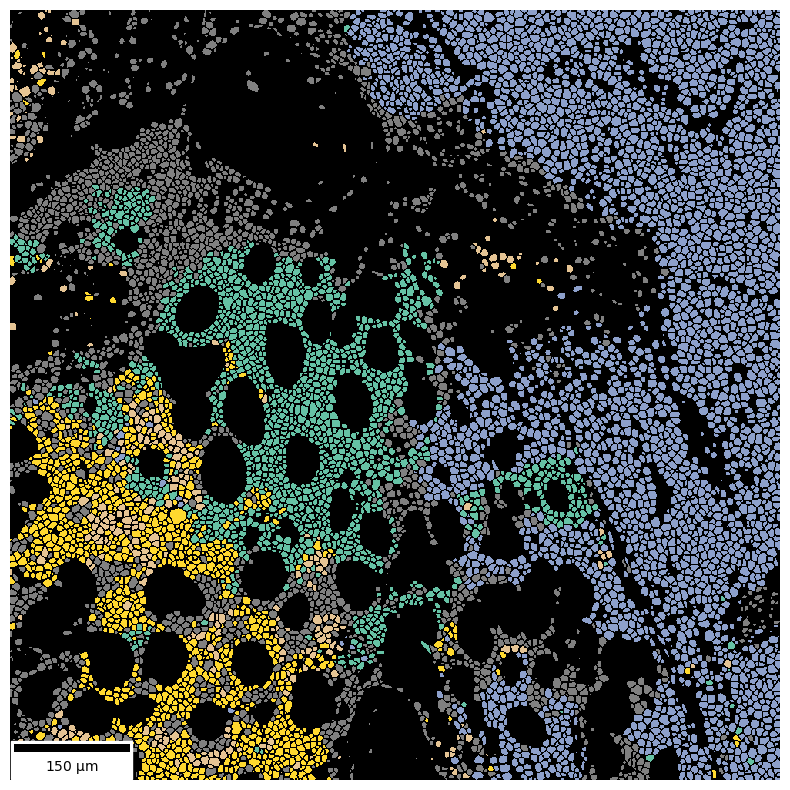

In [24]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC75-1_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'cellcharter_CN' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
neighborhood_color_map2 = neighborhood_color_map.copy()
for key in neighborhood_color_map.keys():
    if key not in ['PC_OXPHOS', 'PC_MYELOID', 'ADAPTIVE_IMMUNE', 'HIF1A_IMMUNE']:
        neighborhood_color_map2[key] = 'grey'
colors_list = [background_color] + [neighborhood_color_map2[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_greyed.{extension}')
            )

# Figure 6

OB/RUNX2+ 1
Unknown 2
DCs 3
MPO+ 4
HSPCs 5
PCs 6
CD8 T 7
Osteocytes 8
HLA-DR+ Macs/monos 9
CD4 T 10
Neutrophils 11
Adipocytes 12
Osteoclasts 13
Macs/monos 14
Endothelial 15


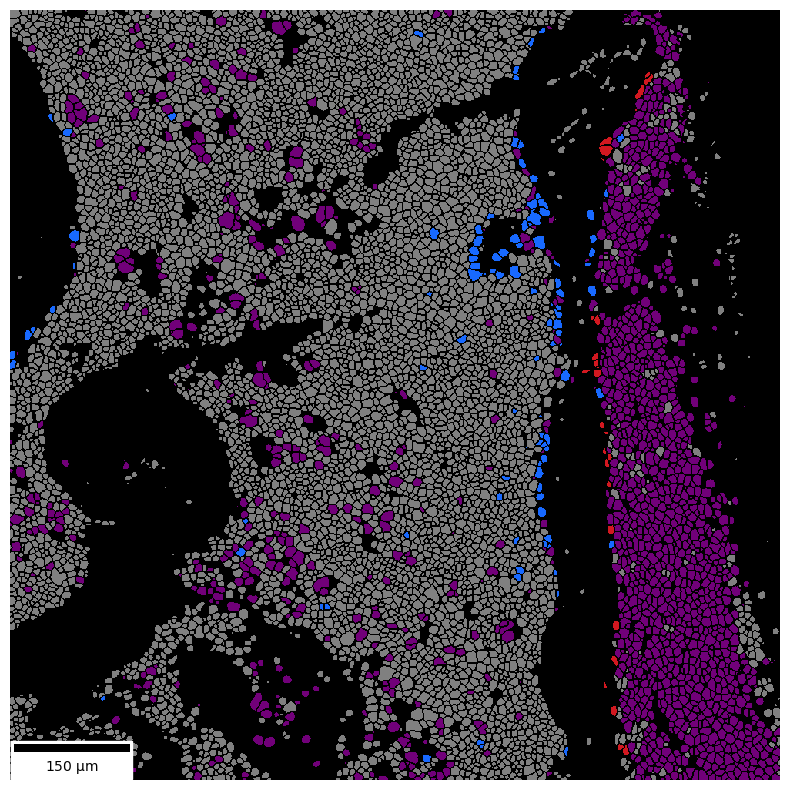

In [50]:
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_6/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_6/{extension}/'
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC43_B_002.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['Phenotype4'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
phenotype_color_map2 = phenotype_color_map.copy()
for key in phenotype_color_map.keys():
    if key not in ['PCs', 'OB/RUNX2+', 'Osteoclasts']:
        phenotype_color_map2[key] = 'grey'
colors_list = [background_color] + [phenotype_color_map2[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_greyed.{extension}')
            )

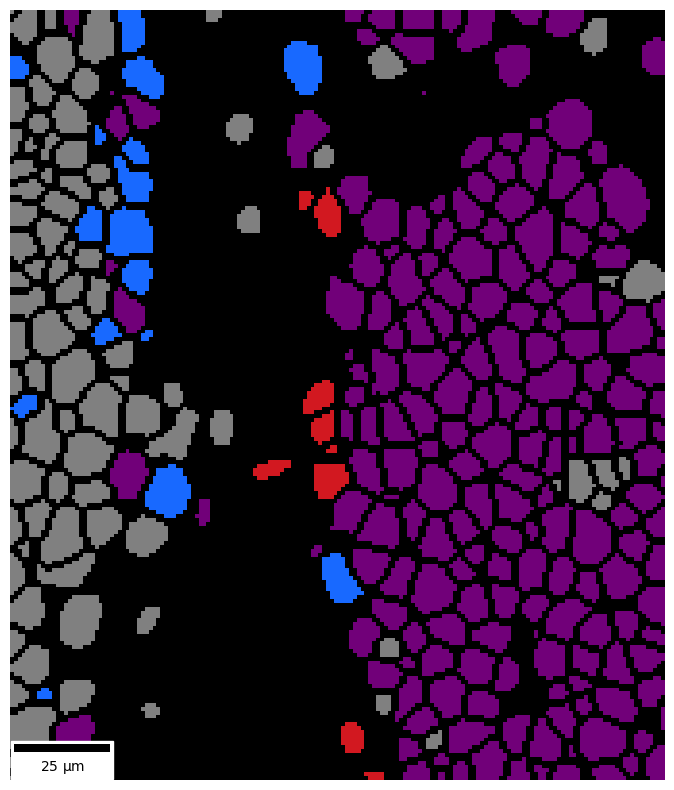

In [51]:
ROI_upper_left = (350, 680)
ROI_lower_right = (550,850)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
phenotype_color_map2 = phenotype_color_map.copy()
for key in phenotype_color_map.keys():
    if key not in ['PCs', 'OB/RUNX2+', 'Osteoclasts']:
        phenotype_color_map2[key] = 'grey'
colors_list = [background_color] + [phenotype_color_map2[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1,
            save_path=os.path.join(save_path, f'{sample.split(".csv")[0]}_{target_col}_crop_greyed.{extension}')
            )

Adipocytes 1
HSPCs 2
Unknown 3
Neutrophils 4
CD8 T 5
DCs 6
Endothelial 7
Macs/monos 8
MPO+ 9
OB/RUNX2+ 10
CD4 T 11
HLA-DR+ Macs/monos 12
PCs 13


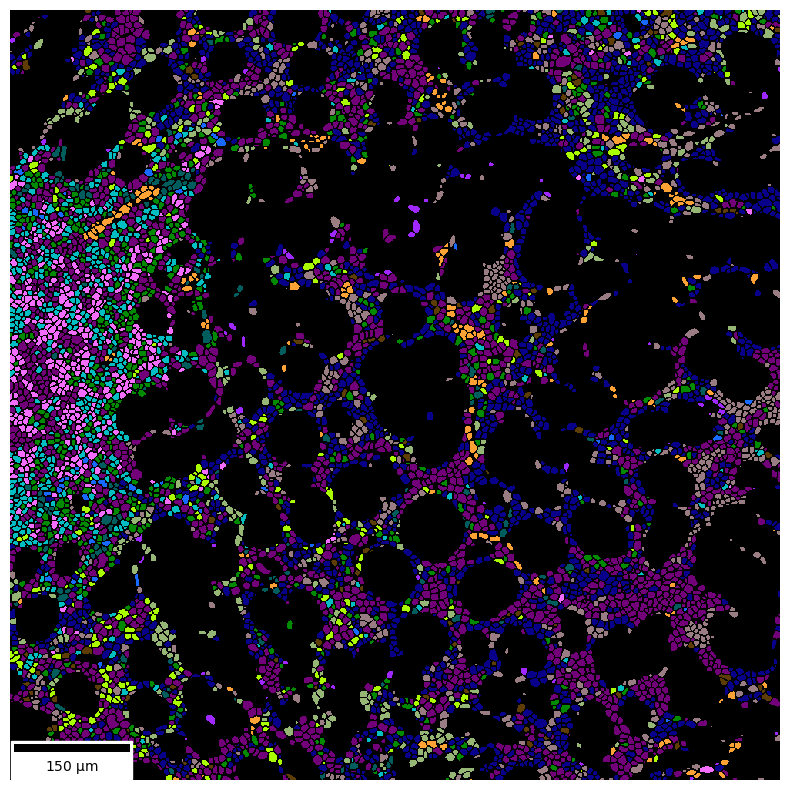

In [22]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC26_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1
            )

Adipocytes 1
Osteoclasts 2
HSPCs 3
Osteocytes 4
Neutrophils 5
Unknown 6
CD8 T 7
Endothelial 8
DCs 9
Macs/monos 10
MPO+ 11
OB/RUNX2+ 12
CD4 T 13
HLA-DR+ Macs/monos 14
PCs 15


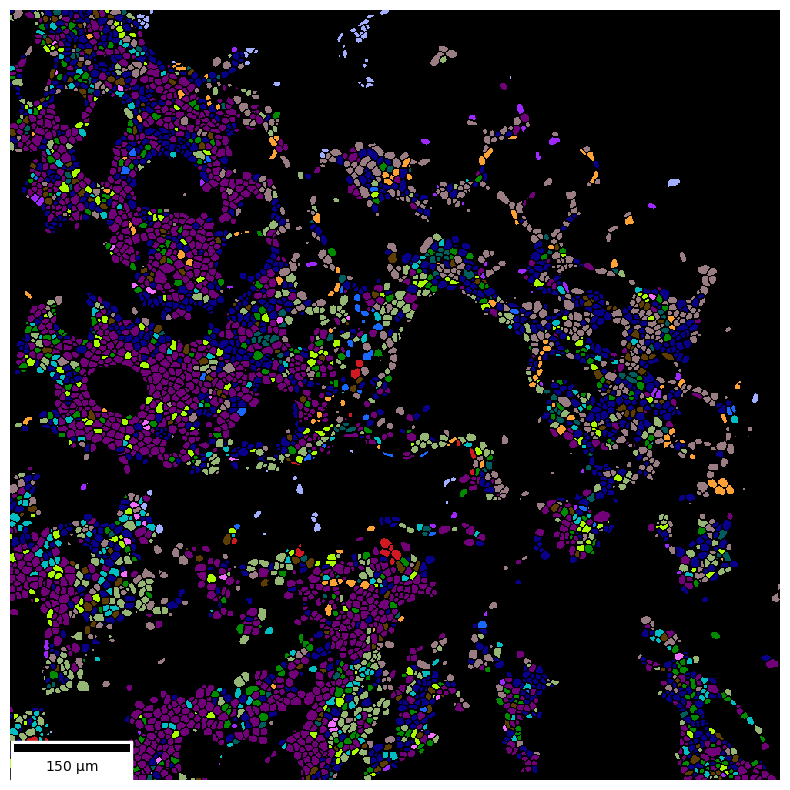

In [6]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC26_B_002.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1
            )

Adipocytes 1
HSPCs 2
Unknown 3
Neutrophils 4
Endothelial 5
CD8 T 6
Osteocytes 7
DCs 8
Macs/monos 9
MPO+ 10
OB/RUNX2+ 11
CD4 T 12
HLA-DR+ Macs/monos 13
PCs 14


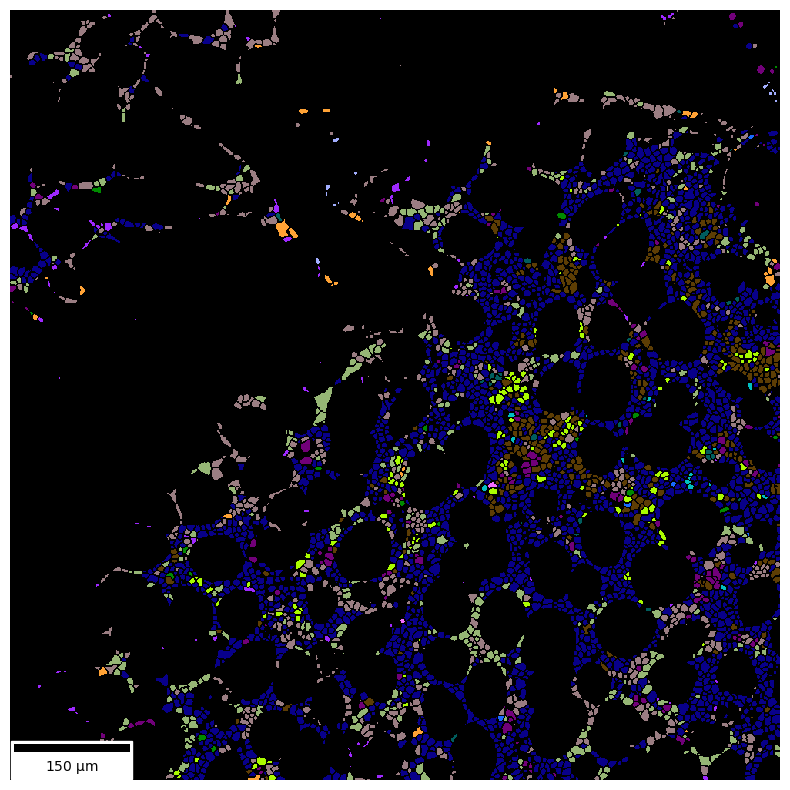

In [13]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC95_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1
            )

Adipocytes 1
HSPCs 2
Unknown 3
Neutrophils 4
CD8 T 5
Endothelial 6
DCs 7
Macs/monos 8
MPO+ 9
OB/RUNX2+ 10
CD4 T 11
HLA-DR+ Macs/monos 12
PCs 13


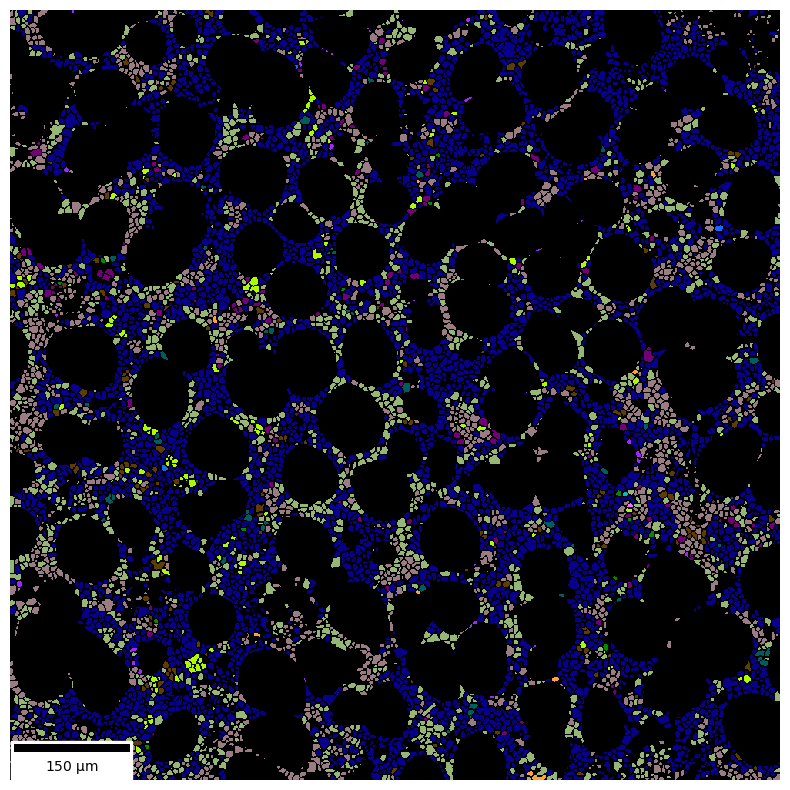

In [24]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC95_B_002.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1
            )

Adipocytes 1
Osteoclasts 2
HSPCs 3
Unknown 4
Neutrophils 5
Endothelial 6
Osteocytes 7
DCs 8
CD8 T 9
Macs/monos 10
MPO+ 11
OB/RUNX2+ 12
CD4 T 13
HLA-DR+ Macs/monos 14
PCs 15


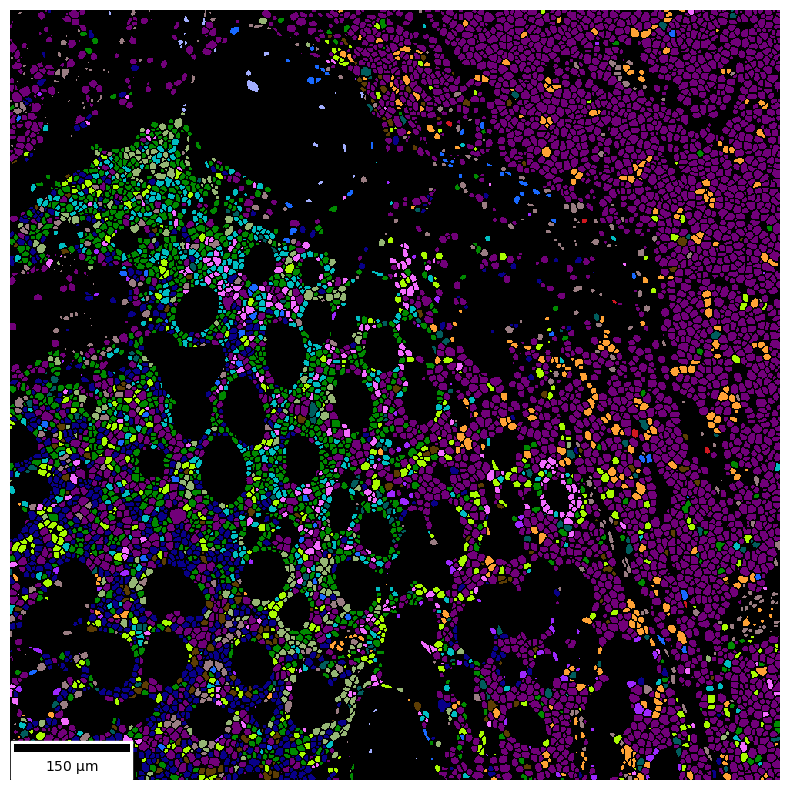

In [19]:
df = adata.to_df()
cell_df_whole = df.join(adata.obs)
sample = 'TS-373_IMC75-1_B_001.csv'
seg_name = sample.split('.csv')[0] + '.tiff'
seg_mask_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/masks/{seg_name}'
cell_df = cell_df_whole.loc[cell_df_whole['image_ID'] == sample]
cell_df = cell_df[cell_df['cellcharter_CN'] != 'exclude']
target_col = 'Phenotype4' # column of interest for color coding
unique_identifiers = set(cell_df[target_col].unique())
segmentation_mask, plot_segmentation = process_full_image(cell_df=cell_df, seg_mask_path=seg_mask_path, target_col=target_col, label_col='Object') # if unsure of which regions to select, I just process the full image then crop the files later - this could be made more efficient by cropping the image before processing
ROI_upper_left = (0, 0)
ROI_lower_right = (1000,1000)
roi_crop, plot_crop = crop_roi(segmentation_mask, plot_segmentation, ROI_upper_left, ROI_lower_right)
background_color = 'black'
colors_list = [background_color] + [phenotype_color_map[identifier] for identifier in unique_identifiers] 
final_cmap = colors.ListedColormap(colors_list)
create_plot(roi_crop=roi_crop, plot_crop=plot_crop, cmap=final_cmap, boundaries=True, boundary_color=(0, 0, 0, 1), boundary_thickness=1
            )

# Distance to bone plot

In [94]:
extension = 'svg'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_1/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_1/{extension}/'

In [59]:
seg_mask_path = '/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/bone_masks_corrected/TS-373_IMC44_B_002_bone_masks.tiff'
seg_mask = tifffile.imread(seg_mask_path)
inverted_seg_mask = np.logical_not(seg_mask).astype(int)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x30f5385b0>)

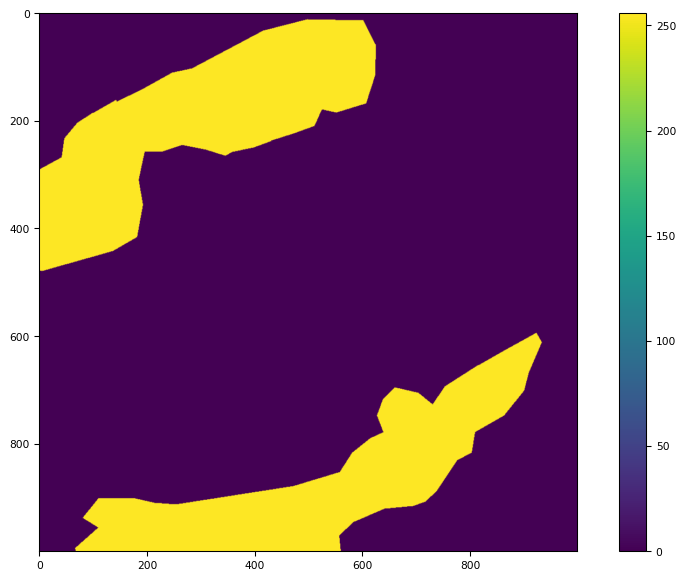

In [60]:
tifffile.imshow(seg_mask)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x30b1ac4c0>)

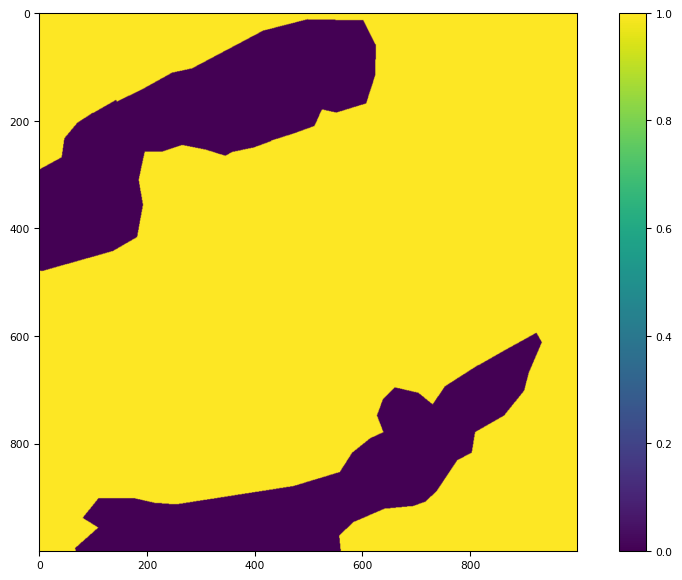

In [61]:
tifffile.imshow(inverted_seg_mask)

In [62]:
distance_transform = distance_transform_edt(inverted_seg_mask)

In [ ]:
overlay_mask = seg_mask == 255
rgba_overlay = np.zeros(seg_mask.shape + (4,), dtype=float)
rgba_overlay[overlay_mask] = [1, 1, 1, 0.5]

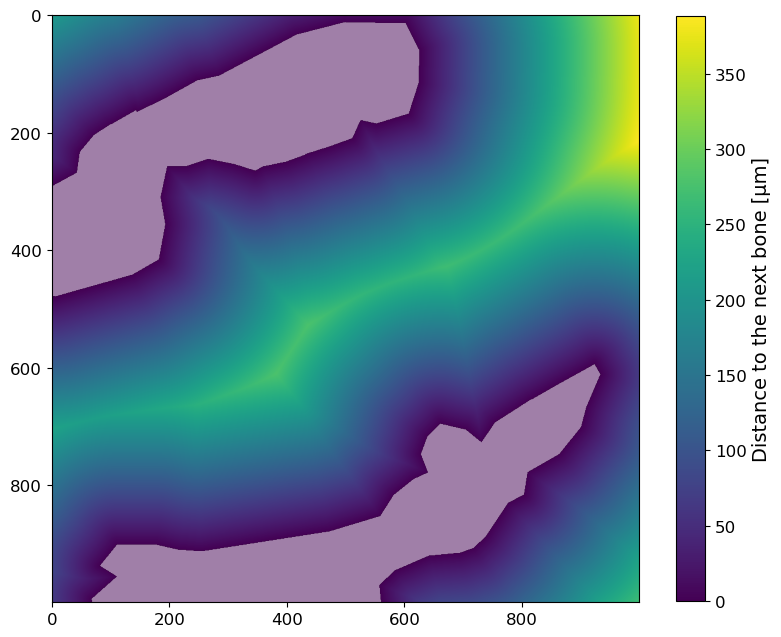

In [100]:
fig, ax = plt.subplots(figsize=(8, 7))
img = ax.imshow(distance_transform, cmap='viridis')
ax.imshow(rgba_overlay, alpha=1)
cbar = fig.colorbar(img, ax=ax, shrink=0.87)
cbar.set_label('Distance to the next bone [µm]', fontsize=14)
cbar.ax.tick_params(labelsize=12)
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path_supp, 'distance_transform_bone_mask.svg'), dpi=300)